In [10]:
# LatticeBoltzmannDemo.py:  a two-dimensional lattice-Boltzmann "wind tunnel" simulation
# Uses numpy to speed up all array handling.
# Uses matplotlib to plot and animate the curl of the macroscopic velocity field.

# Copyright 2013, Daniel V. Schroeder (Weber State University) 2013

# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated data and documentation (the "Software"), to deal in 
# the Software without restriction, including without limitation the rights to 
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies 
# of the Software, and to permit persons to whom the Software is furnished to do 
# so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all 
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
# PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR 
# ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR 
# OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR 
# OTHER DEALINGS IN THE SOFTWARE.

# Except as contained in this notice, the name of the author shall not be used in 
# advertising or otherwise to promote the sale, use or other dealings in this 
# Software without prior written authorization.

# Credits:
# The "wind tunnel" entry/exit conditions are inspired by Graham Pullan's code
# (http://www.many-core.group.cam.ac.uk/projects/LBdemo.shtml).  Additional inspiration from 
# Thomas Pohl's applet (http://thomas-pohl.info/work/lba.html).  Other portions of code are based 
# on Wagner (http://www.ndsu.edu/physics/people/faculty/wagner/lattice_boltzmann_codes/) and
# Gonsalves (http://www.physics.buffalo.edu/phy411-506-2004/index.html; code adapted from Succi,
# http://global.oup.com/academic/product/the-lattice-boltzmann-equation-9780199679249).

# For related materials see http://physics.weber.edu/schroeder/fluids

import numpy, time, matplotlib.pyplot, matplotlib.animation
from numba import jit, cuda

# Define constants:
height = 80							# lattice dimensions
width = 200
viscosity = 0.005					# fluid viscosity
omega = 1 / (3*viscosity + 0.5)		# "relaxation" parameter
u0 = 0.1							# initial and in-flow speed
four9ths = 4.0/9.0					# abbreviations for lattice-Boltzmann weight factors
one9th   = 1.0/9.0
one36th  = 1.0/36.0
performanceData = False				# set to True if performance data is desired

BLOCK_SIZE = 8















In [11]:
# Initialize all the arrays to steady rightward flow:
n0 = four9ths * (numpy.ones((height,width)) - 1.5*u0**2)	# particle densities along 9 directions
nN = one9th * (numpy.ones((height,width)) - 1.5*u0**2)
nS = one9th * (numpy.ones((height,width)) - 1.5*u0**2)
nE = one9th * (numpy.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nW = one9th * (numpy.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nNE = one36th * (numpy.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nSE = one36th * (numpy.ones((height,width)) + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nNW = one36th * (numpy.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
nSW = one36th * (numpy.ones((height,width)) - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW		# macroscopic density
ux = (nE + nNE + nSE - nW - nNW - nSW) / rho				# macroscopic x velocity
uy = (nN + nNE + nNW - nS - nSE - nSW) / rho				# macroscopic y velocity


In [12]:
# Initialize barriers:
barrier = numpy.zeros((height,width), bool)					# True wherever there's a barrier
barrier[(int)(height/2)-8:(int)(height/2)+8, (int)(height/2)] = True			# simple linear barrier
barrierN = numpy.roll(barrier,  1, axis=0)					# sites just north of barriers
barrierS = numpy.roll(barrier, -1, axis=0)					# sites just south of barriers
barrierE = numpy.roll(barrier,  1, axis=1)					# etc.
barrierW = numpy.roll(barrier, -1, axis=1)
barrierNE = numpy.roll(barrierN,  1, axis=1)
barrierNW = numpy.roll(barrierN, -1, axis=1)
barrierSE = numpy.roll(barrierS,  1, axis=1)
barrierSW = numpy.roll(barrierS, -1, axis=1)

In [19]:
# Move all particles by one step along their directions of motion (pbc):
#@jit
def stream():
    
	global nN, nS, nE, nW, nNE, nNW, nSE, nSW
	nN  = numpy.roll(nN,   1, axis=0)	# axis 0 is north-south; + direction is north
	nNE = numpy.roll(nNE,  1, axis=0)
	nNW = numpy.roll(nNW,  1, axis=0)
	nS  = numpy.roll(nS,  -1, axis=0)
	nSE = numpy.roll(nSE, -1, axis=0)
	nSW = numpy.roll(nSW, -1, axis=0)
	nE  = numpy.roll(nE,   1, axis=1)	# axis 1 is east-west; + direction is east
	nNE = numpy.roll(nNE,  1, axis=1)
	nSE = numpy.roll(nSE,  1, axis=1)
	nW  = numpy.roll(nW,  -1, axis=1)
	nNW = numpy.roll(nNW, -1, axis=1)
	nSW = numpy.roll(nSW, -1, axis=1)
	# Use tricky boolean arrays to handle barrier collisions (bounce-back):
	nN[barrierN] = nS[barrier]
	nS[barrierS] = nN[barrier]
	nE[barrierE] = nW[barrier]
	nW[barrierW] = nE[barrier]
	nNE[barrierNE] = nSW[barrier]
	nNW[barrierNW] = nSE[barrier]
	nSE[barrierSE] = nNW[barrier]
	nSW[barrierSW] = nNE[barrier]
		

In [20]:



#@jit
# Collide particles within each cell to redistribute velocities (could be optimized a little more):
def collide():
	global rho, ux, uy, n0, nN, nS, nE, nW, nNE, nNW, nSE, nSW
	rho = n0 + nN + nS + nE + nW + nNE + nSE + nNW + nSW
	ux = (nE + nNE + nSE - nW - nNW - nSW) / rho
	uy = (nN + nNE + nNW - nS - nSE - nSW) / rho
	ux2 = ux * ux				# pre-compute terms used repeatedly...
	uy2 = uy * uy
	u2 = ux2 + uy2
	omu215 = 1 - 1.5*u2			# "one minus u2 times 1.5"
	uxuy = ux * uy
	n0 = (1-omega)*n0 + omega * four9ths * rho * omu215
	nN = (1-omega)*nN + omega * one9th * rho * (omu215 + 3*uy + 4.5*uy2)
	nS = (1-omega)*nS + omega * one9th * rho * (omu215 - 3*uy + 4.5*uy2)
	nE = (1-omega)*nE + omega * one9th * rho * (omu215 + 3*ux + 4.5*ux2)
	nW = (1-omega)*nW + omega * one9th * rho * (omu215 - 3*ux + 4.5*ux2)
	nNE = (1-omega)*nNE + omega * one36th * rho * (omu215 + 3*(ux+uy) + 4.5*(u2+2*uxuy))
	nNW = (1-omega)*nNW + omega * one36th * rho * (omu215 + 3*(-ux+uy) + 4.5*(u2-2*uxuy))
	nSE = (1-omega)*nSE + omega * one36th * rho * (omu215 + 3*(ux-uy) + 4.5*(u2-2*uxuy))
	nSW = (1-omega)*nSW + omega * one36th * rho * (omu215 + 3*(-ux-uy) + 4.5*(u2+2*uxuy))
	# Force steady rightward flow at ends (no need to set 0, N, and S components):
	nE[:,0] = one9th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nW[:,0] = one9th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nNE[:,0] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nSE[:,0] = one36th * (1 + 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nNW[:,0] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)
	nSW[:,0] = one36th * (1 - 3*u0 + 4.5*u0**2 - 1.5*u0**2)

In [21]:
# Compute curl of the macroscopic velocity field:
def curl(ux, uy):
	return numpy.roll(uy,-1,axis=1) - numpy.roll(uy,1,axis=1) - numpy.roll(ux,-1,axis=0) + numpy.roll(ux,1,axis=0)

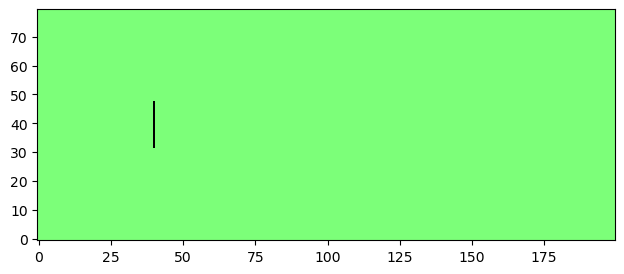

In [22]:
# Here comes the graphics and animation...
theFig = matplotlib.pyplot.figure(figsize=(8,3))
fluidImage = matplotlib.pyplot.imshow(curl(ux, uy), origin='lower', norm=matplotlib.pyplot.Normalize(-.1,.1), 
									cmap=matplotlib.pyplot.get_cmap('jet'), interpolation='none')
		# See http://www.loria.fr/~rougier/teaching/matplotlib/#colormaps for other cmap options
bImageArray = numpy.zeros((height, width, 4), numpy.uint8)	# an RGBA image
bImageArray[barrier,3] = 255								# set alpha=255 only at barrier sites
barrierImage = matplotlib.pyplot.imshow(bImageArray, origin='lower', interpolation='none')

In [23]:
# Function called for each successive animation frame:
clk_id1 = 0
startTime = time.clock_gettime_ns(clk_id1)
#frameList = open('frameList.txt','w')		# file containing list of images (to make movie)
                        
def nextFrame(arg):# (arg is the frame number, which we don't need)
    global startTime
    if performanceData and (arg%100 == 0) and (arg > 0):
        endTime = time.clock_gettime_ns(clk_id1)
        print("%1.1f" % (100/(endTime-startTime)), 'frames per second')
        startTime = endTime
    #frameName = "frame%04d.png" % arg
    #matplotlib.pyplot.savefig(frameName)
    #frameList.write(frameName + '\n')
    for step in range(20):					# adjust number of steps for smooth animation
        stream()
        collide()
    fluidImage.set_array(curl(ux, uy))
    return (fluidImage, barrierImage)		# return the figure elements to redraw

In [24]:
#threadsperblock = 32
#an_array = numpy.array(1)
#blockspergrid = (an_array.size + (threadsperblock - 1)) // threadsperblock
#increment_by_one[blockspergrid, threadsperblock](an_array)

animate = matplotlib.animation.FuncAnimation(theFig, nextFrame, interval=1, save_count=500)
animate.save('2d.gif', writer = 'ffmpeg', fps =32)